In [75]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import mean_absolute_error, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import chi2, SelectKBest

from imblearn.over_sampling import SMOTE

import copy

from datetime import datetime, date

In [76]:
trainData = pd.read_csv('./pitch_project_data.csv')

In [37]:
#Functions for cleaning the data later
def cleanDate(input):
    if '/' in input:
        return input
    else:
        return '1/1/1950'

def calculateAge(born):
    today = date.today()
    return today.year - born.year

def checkFeaturePresent(input):
    if input != 0:
        return 1
    else:
        return 0

In [77]:
#Creating train and test data
data = trainData.sort_values(by = ['year'])
testData = data.loc[data['year'] == 2018].drop(['org_top10_post'], axis = 1)
data = data[data.year != 2018]

In [78]:
testData

,bcubeID,year,teamName,league,level,levelID,orgName,firstName,lastName,fullName,...,milb_debut,mlb_binary,milb_exp,ba100_post,sign_bonus_mill,cpi_factor,sign_bonus_mill_cpi_adj,college,bloodlines,draft_round
91716,208338,2018,Azl Cubs,ARIZ,Rk,1,CHN,Carlos,Ocampo,Carlos Ocampo,...,2016,0,3,0,NaN,1.05,NaN,NaN,NaN,9999
56485,148166,2018,NW Arkansas,TEX,AA,5,KCA,Sam,Selman,Sam Selman,...,2012,0,7,0,0.7500,1.10,0.825000,"Vanderbilt University (Nashville,TN)",NaN,2
94450,216255,2018,GCL Pirates,GCL,Rk,1,PIT,Andres,Arrieta,Andres Arrieta,...,2018,0,1,0,NaN,1.00,NaN,NaN,NaN,9999
91817,208409,2018,Charleston (Sc),SAL,A,3,NYA,Deivi,Garcia,Deivi Garcia,...,2016,0,3,0,0.2000,1.05,0.210000,NaN,NaN,9999
94511,216365,2018,DSL Pirates 2,DSL,Rk,1,PIT,Denny,Roman,Denny Roman,...,2018,0,1,0,NaN,1.00,NaN,NaN,NaN,9999
94441,216238,2018,Orem,PIO,Rk,1,ANA,Christian,Aragon,Christian Aragon,...,2018,0,1,0,NaN,1.00,NaN,"University of South Carolina-Aiken (Aiken,SC)...",NaN,9999
54748,145274,2018,Charlotte,IL,AAA,6,CHA,Asher,Wojciechowski,Asher Wojciechowski,...,2010,1,9,0,0.8154,1.16,0.945864,"The Citadel (Charleston,SC)",NaN,1
94543,216405,2018,DSL Royals,DSL,Rk,1,KCA,Junior,Almonte,Junior Almonte,...,2018,0,1,0,NaN,1.00,NaN,NaN,NaN,9999
91676,208317,2018,Brooklyn,NYPL,A-,2,NYN,Briam,Campusano,Briam Campusano,...,2016,0,3,0,NaN,1.05,NaN,NaN,NaN,9999
91829,208414,2018,Missoula,PIO,Rk,1,ARI,Deyni,Olivero,Deyni Olivero,...,2016,0,3,0,NaN,1.05,NaN,NaN,NaN,9999


In [40]:
#Dropped level cause LevelID does enough telling that, dropped sign on bonus with inflation factor and just kept the inflated value
#Dropping the useless rows
data = data.drop(['bcubeID', 'level', 'teamName', 'firstName', 'lastName', 'fullName', 'sign_bonus_mill', 'cpi_factor', 'college', 'dob', 'er', 'hits', 'hr', 'bb', 'so'], axis = 1)

In [41]:
data

,year,league,levelID,orgName,wins,loss,gm,gs,cg,sho,...,bats,throws,milb_debut,mlb_binary,milb_exp,ba100_post,org_top10_post,sign_bonus_mill_cpi_adj,bloodlines,draft_round
9461,1999,NYPL,2,FLO,2,0,5,5,0,0,...,L,R,1999,1,1,0,0,NaN,Brother of Matt Robertson,5
28531,1999,APP,1,HOU,6,4,14,13,1,0,...,R,R,1999,0,1,0,0,NaN,NaN,16
1419,1999,ARIZ,1,ARI,2,1,17,0,0,0,...,R,R,1999,0,1,0,0,NaN,NaN,9999
28526,1999,NYPL,2,HOU,1,2,23,0,0,0,...,L,L,1999,0,1,0,0,NaN,NaN,34
1418,1999,ARIZ,1,SEA,0,1,19,0,0,0,...,R,R,1999,0,1,0,0,NaN,NaN,9999
6710,1999,ARIZ,1,SEA,2,0,13,0,0,0,...,B,L,1999,0,1,0,0,NaN,NaN,9999
48159,1999,PIO,1,LAN,0,0,4,0,0,0,...,R,R,1999,0,1,0,0,NaN,NaN,9999
28506,1999,NYPL,2,NYA,0,1,2,2,0,0,...,R,R,1999,0,1,0,0,NaN,NaN,8
992,1999,PIO,1,MIL,0,0,1,0,0,0,...,R,R,1999,0,1,0,0,NaN,NaN,9999
28504,1999,PIO,1,MIL,6,1,14,8,2,0,...,R,R,1999,0,1,0,0,NaN,NaN,17


In [42]:
#Fill bloodlines NaN with 0 with no bloodline, if bloodline put 1
data.loc[data['bloodlines'].notnull(), 'bloodlines'] = 1
data['bloodlines'] = data['bloodlines'].fillna(0)

In [43]:
data

,year,league,levelID,orgName,wins,loss,gm,gs,cg,sho,...,bats,throws,milb_debut,mlb_binary,milb_exp,ba100_post,org_top10_post,sign_bonus_mill_cpi_adj,bloodlines,draft_round
9461,1999,NYPL,2,FLO,2,0,5,5,0,0,...,L,R,1999,1,1,0,0,NaN,1,5
28531,1999,APP,1,HOU,6,4,14,13,1,0,...,R,R,1999,0,1,0,0,NaN,0,16
1419,1999,ARIZ,1,ARI,2,1,17,0,0,0,...,R,R,1999,0,1,0,0,NaN,0,9999
28526,1999,NYPL,2,HOU,1,2,23,0,0,0,...,L,L,1999,0,1,0,0,NaN,0,34
1418,1999,ARIZ,1,SEA,0,1,19,0,0,0,...,R,R,1999,0,1,0,0,NaN,0,9999
6710,1999,ARIZ,1,SEA,2,0,13,0,0,0,...,B,L,1999,0,1,0,0,NaN,0,9999
48159,1999,PIO,1,LAN,0,0,4,0,0,0,...,R,R,1999,0,1,0,0,NaN,0,9999
28506,1999,NYPL,2,NYA,0,1,2,2,0,0,...,R,R,1999,0,1,0,0,NaN,0,8
992,1999,PIO,1,MIL,0,0,1,0,0,0,...,R,R,1999,0,1,0,0,NaN,0,9999
28504,1999,PIO,1,MIL,6,1,14,8,2,0,...,R,R,1999,0,1,0,0,NaN,0,17


In [44]:
#Fill sign on bonus NaN with 0
data['sign_bonus_mill_cpi_adj'] = data['sign_bonus_mill_cpi_adj'].fillna(0)

#Making an age column
# data['dob'] = data['dob'].apply(lambda x: cleanDate(x))
# data['dob'] = pd.to_datetime(data['dob'], format = '%m/%d/%Y')
# data['age'] = data['dob'].apply(lambda x: calculateAge(x))
# data['age'] = data['age'].replace([69], 0)
# data['agePresent'] = data['age'].apply(lambda x: checkFeaturePresent(x))

In [45]:
data

,year,league,levelID,orgName,wins,loss,gm,gs,cg,sho,...,bats,throws,milb_debut,mlb_binary,milb_exp,ba100_post,org_top10_post,sign_bonus_mill_cpi_adj,bloodlines,draft_round
9461,1999,NYPL,2,FLO,2,0,5,5,0,0,...,L,R,1999,1,1,0,0,0.000000,1,5
28531,1999,APP,1,HOU,6,4,14,13,1,0,...,R,R,1999,0,1,0,0,0.000000,0,16
1419,1999,ARIZ,1,ARI,2,1,17,0,0,0,...,R,R,1999,0,1,0,0,0.000000,0,9999
28526,1999,NYPL,2,HOU,1,2,23,0,0,0,...,L,L,1999,0,1,0,0,0.000000,0,34
1418,1999,ARIZ,1,SEA,0,1,19,0,0,0,...,R,R,1999,0,1,0,0,0.000000,0,9999
6710,1999,ARIZ,1,SEA,2,0,13,0,0,0,...,B,L,1999,0,1,0,0,0.000000,0,9999
48159,1999,PIO,1,LAN,0,0,4,0,0,0,...,R,R,1999,0,1,0,0,0.000000,0,9999
28506,1999,NYPL,2,NYA,0,1,2,2,0,0,...,R,R,1999,0,1,0,0,0.000000,0,8
992,1999,PIO,1,MIL,0,0,1,0,0,0,...,R,R,1999,0,1,0,0,0.000000,0,9999
28504,1999,PIO,1,MIL,6,1,14,8,2,0,...,R,R,1999,0,1,0,0,0.000000,0,17


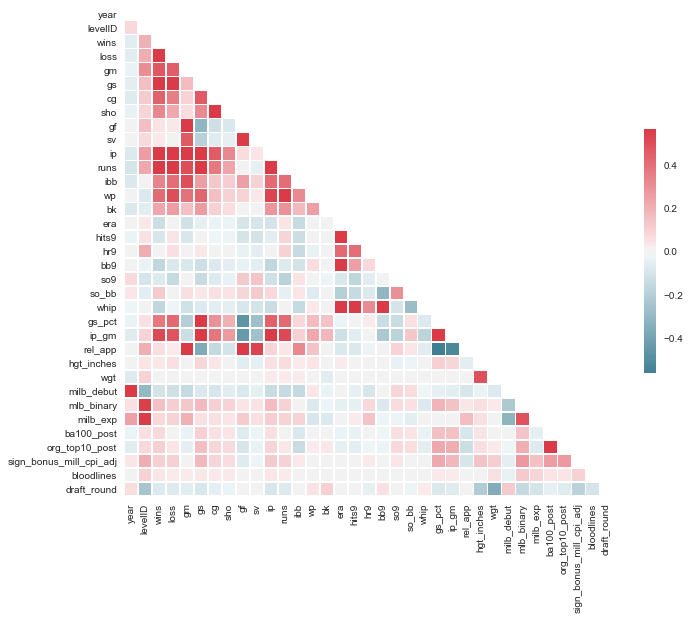

In [46]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [47]:
#Cleaning features

"""
Replacing all NaNs with 0 and then if there was an entry, append another column
indicating if that feature was originally present
"""

featuresToClean = ['gf', 'sv', 'ibb', 'wp', 'bk', 'hits9', 'hr9', 'so9', 'bb9', 'hgt_inches', 'sign_bonus_mill_cpi_adj']
for features in featuresToClean:
    data[features] = data[features].fillna(0)
    data[features + 'Present'] = data[features].apply(lambda x: checkFeaturePresent(x))

In [48]:
data['gf']

9461      0.0
28531     0.0
1419      4.0
28526     8.0
1418     11.0
6710      2.0
48159     3.0
28506     0.0
992       1.0
28504     4.0
28503     1.0
6732      0.0
605       0.0
606       0.0
6733      0.0
48145     0.0
11446    12.0
20258     0.0
28494     7.0
28493    23.0
28492     0.0
1225      2.0
28490     0.0
28489     1.0
20158     4.0
994       6.0
995       5.0
996       5.0
1436      0.0
20026    11.0
         ... 
36321     9.0
83049     0.0
76312     0.0
76612     3.0
76590     1.0
82234     0.0
76613    10.0
76521     0.0
80459    20.0
76582     0.0
80546    12.0
42572     3.0
76303    10.0
83146     1.0
83015    11.0
83152     0.0
76264     0.0
76298     1.0
76259     0.0
76255     1.0
82084     8.0
80214     3.0
80242     0.0
83031     1.0
80470     1.0
83018     0.0
76591     0.0
80471     0.0
81896     0.0
83017     2.0
Name: gf, dtype: float64

In [49]:
data['gfPresent']

9461     0
28531    0
1419     1
28526    1
1418     1
6710     1
48159    1
28506    0
992      1
28504    1
28503    1
6732     0
605      0
606      0
6733     0
48145    0
11446    1
20258    0
28494    1
28493    1
28492    0
1225     1
28490    0
28489    1
20158    1
994      1
995      1
996      1
1436     0
20026    1
        ..
36321    1
83049    0
76312    0
76612    1
76590    1
82234    0
76613    1
76521    0
80459    1
76582    0
80546    1
42572    1
76303    1
83146    1
83015    1
83152    0
76264    0
76298    1
76259    0
76255    1
82084    1
80214    1
80242    0
83031    1
80470    1
83018    0
76591    0
80471    0
81896    0
83017    1
Name: gfPresent, dtype: int64

In [50]:
data

,year,league,levelID,orgName,wins,loss,gm,gs,cg,sho,...,svPresent,ibbPresent,wpPresent,bkPresent,hits9Present,hr9Present,so9Present,bb9Present,hgt_inchesPresent,sign_bonus_mill_cpi_adjPresent
9461,1999,NYPL,2,FLO,2,0,5,5,0,0,...,0,0,0,0,1,0,1,1,1,0
28531,1999,APP,1,HOU,6,4,14,13,1,0,...,0,0,1,0,1,1,1,1,1,0
1419,1999,ARIZ,1,ARI,2,1,17,0,0,0,...,1,0,1,1,1,1,1,1,1,0
28526,1999,NYPL,2,HOU,1,2,23,0,0,0,...,0,0,1,0,1,1,1,1,1,0
1418,1999,ARIZ,1,SEA,0,1,19,0,0,0,...,1,0,1,1,1,1,1,1,1,0
6710,1999,ARIZ,1,SEA,2,0,13,0,0,0,...,0,0,1,0,1,0,1,1,1,0
48159,1999,PIO,1,LAN,0,0,4,0,0,0,...,0,0,0,1,1,0,1,1,1,0
28506,1999,NYPL,2,NYA,0,1,2,2,0,0,...,0,0,1,1,1,1,1,1,1,0
992,1999,PIO,1,MIL,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,1,0
28504,1999,PIO,1,MIL,6,1,14,8,2,0,...,1,0,1,0,1,1,1,1,1,0


In [51]:
#One hot encode the features as you don't want to assume feature

#3 common ways to preprocess data

"""
1. Feature order (0, 1, 2, 3)
2. One hot encoding
3. Feature hashing
"""
oneHotFeatures = ['throws', 'bats', 'orgName', 'league']
for features in oneHotFeatures:
    dummy = pd.get_dummies(data[features], prefix = features)
    data = data.drop([features], axis = 1)
    data = pd.concat((data, dummy), axis = 1)

In [52]:
data

,year,levelID,wins,loss,gm,gs,cg,sho,gf,sv,...,league_IL,league_MIDW,league_MLB,league_NWST,league_NYPL,league_PCL,league_PIO,league_SAL,league_SOU,league_TEX
9461,1999,2,2,0,5,5,0,0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
28531,1999,1,6,4,14,13,1,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1419,1999,1,2,1,17,0,0,0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
28526,1999,2,1,2,23,0,0,0,8.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1418,1999,1,0,1,19,0,0,0,11.0,7.0,...,0,0,0,0,0,0,0,0,0,0
6710,1999,1,2,0,13,0,0,0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
48159,1999,1,0,0,4,0,0,0,3.0,0.0,...,0,0,0,0,0,0,1,0,0,0
28506,1999,2,0,1,2,2,0,0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
992,1999,1,0,0,1,0,0,0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
28504,1999,1,6,1,14,8,2,0,4.0,4.0,...,0,0,0,0,0,0,1,0,0,0


In [53]:
data.shape

(87711, 142)

In [54]:
#Dimensionality reduction
tempLabel = data['org_top10_post']
tempData = data.drop(['org_top10_post'], axis = 1)
tempData[tempData < 0] = 0

fitter = SelectKBest(chi2, k = 50).fit(tempData, tempLabel)
stupid = fitter.transform(tempData)

In [55]:
Y = data['org_top10_post']
#X = data.drop(['org_top10_post'], axis = 1)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(stupid, Y, test_size = 0.25, random_state = 20)
y_val = y_val.tolist()

In [57]:
"""
maybe don't oversample with a 1 to 1 ratio because

False positive: Think they'd make it big but they don't
False negative: Think they won't make it big but they will

minimize false positive becuase you don't want clients "promised" a certain amount of money and then be discouraged that
they dont' get it.

It's a much more pleasant surprise to say you won't get much and then get a lot
"""

sm = SMOTE(random_state = 12, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

/Users/CraigFan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [58]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (125252, 50)
After OverSampling, the shape of train_y: (125252,) 

After OverSampling, counts of label '1': 62626
After OverSampling, counts of label '0': 62626


In [59]:
forestClf = RandomForestClassifier(max_depth = 20)
forestClf.fit(X_train, y_train)
#forestClf.fit(X_train_res, y_train_res)

nnClf = MLPClassifier()
nnClf.fit(X_train, y_train)
#nnClf.fit(X_train_res, y_train_res)

logisticClf = LogisticRegression()
logisticClf.fit(X_train, y_train)
#logisticClf.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
forestPredictions = forestClf.predict(X_val)
forestScore = precision_score(forestPredictions, y_val)
forestRecall = recall_score(forestPredictions, y_val)
forestF1 = f1_score(forestPredictions, y_val)
forestAccuracy = mean_absolute_error(forestPredictions, y_val)

nnPrediction = nnClf.predict(X_val)
nnScore = precision_score(nnPrediction, y_val)
nnRecall = recall_score(nnPrediction, y_val)
nnF1 = f1_score(nnPrediction, y_val)

logisticPredictions = logisticClf.predict(X_val)
logisticF1 = f1_score(logisticPredictions, y_val)

#other = mean_absolute_error(nnPrediction, y_val)

#scv = StratifiedKFold(n_splits = 4)
#score = cross_val_score(forestClf, X, Y, cv = scv)

#print(score)
print(forestScore, nnScore)
print()
print(forestRecall, nnRecall)
print()
print(forestF1, nnF1, logisticF1)
print()
print(forestAccuracy)

0.572259941804 0.691561590689

0.644104803493 0.371160853722

0.606060606061 0.483062330623 0.403661327231

0.0349781101788


In [61]:
scores = cross_val_score(forestClf, X_val, y_val, cv = 7, scoring = 'f1')
scores

array([ 0.4375    ,  0.49765258,  0.59259259,  0.53333333,  0.61135371,
        0.55045872,  0.55963303])

In [62]:
tn, fp, fn, tp = confusion_matrix(forestPredictions, y_val).ravel()
tn, fp, fn, tp

(20571, 441, 326, 590)

In [63]:
forestPredictions.shape

(21928,)

In [514]:
# falseNegative = 0
# falsePositive = 0
# counter = 0
# error = []
# print('Occurances of 1 and 0')
# print(y_val.count(1), y_val.count(0))
# for i in range(len(forestPredictions)):
#     if forestPredictions[i] != y_val[i]:
#         error.append((forestPredictions[i], y_val[i]))
#         counter += 1
#         if y_val[i] == 1:
#             falseNegative += 1
#         else:
#             falsePositive += 1
# print('Errors', 'Total')
# print(counter, len(forestPredictions))
# #print(error)
# print('falseNegative', 'falsePositive')
# print(falseNegative, falsePositive)

Occurances of 1 and 0
1031 20897
Errors Total
778 21928
falseNegative falsePositive
464 314


In [252]:
# missedPro = 0
# nobody = 0
# counter = 0
# error = []
# print('Occurances of 1 and 0')
# print(y_val.count(1), y_val.count(0))
# for i in range(len(forestPredictions)):
#     if nnPrediction[i] != y_val[i]:
#         error.append((nnPrediction[i], y_val[i]))
#         counter += 1
#         if y_val[i] == 1:
#             missedPro += 1
#         else:
#             nobody += 1
# print('Errors', 'Total')
# print(counter, len(forestPredictions))
# #print(error)
# print(missedPro, nobody)

Occurances of 1 and 0
1031 20897
Errors Total
11582 21928
127 11455


In [253]:
# falseNegative = 0
# falsePositive = 0
# counter = 0
# error = []
# print('Occurances of 1 and 0')
# print(y_val.count(1), y_val.count(0))
# for i in range(len(forestPredictions)):
#     if logisticPredictions[i] != y_val[i]:
#         error.append((logisticPredictions[i], y_val[i]))
#         counter += 1
#         if y_val[i] == 1:
#             falseNegative += 1
#         else:
#             falsePositive += 1
# print('Errors', 'Total')
# print(counter, len(forestPredictions))
# #print(error)
# print('falseNegative', 'falsePositive')
# print(falseNegative, falsePositive)

Occurances of 1 and 0
1031 20897
Errors Total
1868 21928
falseNegative falsePositive
201 1667


In [64]:
dupeTest = testData

dupeTest = dupeTest.drop(['bcubeID', 'level', 'teamName', 'firstName', 'lastName', 'fullName', 'sign_bonus_mill', 'cpi_factor', 'college', 'dob', 'er', 'hits', 'hr', 'bb', 'so'], axis = 1)
#Fill bloodlines NaN with 0 with no bloodline, if bloodline put 1
dupeTest.loc[dupeTest['bloodlines'].notnull(), 'bloodlines'] = 1
dupeTest['bloodlines'] = dupeTest['bloodlines'].fillna(0)

#Fill sign on bonus NaN with 0
dupeTest['sign_bonus_mill_cpi_adj'] = dupeTest['sign_bonus_mill_cpi_adj'].fillna(0)

#Cleaning features
featuresToClean = ['gf', 'sv', 'ibb', 'wp', 'bk', 'hits9', 'hr9', 'so9', 'bb9', 'hgt_inches', 'sign_bonus_mill_cpi_adj']
for features in featuresToClean:
    dupeTest[features] = dupeTest[features].fillna(0)
    dupeTest[features + 'Present'] = dupeTest[features].apply(lambda x: checkFeaturePresent(x))

#One hot encode
oneHotFeatures = ['throws', 'bats', 'orgName', 'league']
for features in oneHotFeatures:
    dummy = pd.get_dummies(dupeTest[features], prefix = features)
    dupeTest = dupeTest.drop([features], axis = 1)
    dupeTest = pd.concat((dupeTest, dummy), axis = 1)

In [65]:
missing_cols = set(data.columns) - set(dupeTest.columns)
for c in missing_cols:
    dupeTest[c] = 0
dupeTest = dupeTest[data.columns]
dupeTest = dupeTest.drop(['org_top10_post'], axis = 1)

In [66]:
dupeTest.shape, tempData.shape

((7373, 141), (87711, 141))

In [67]:
dupeTest = fitter.transform(dupeTest)

In [68]:
dupeTest.shape

(7373, 50)

In [69]:
testPredictions = forestClf.predict(dupeTest)
testPredictions

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
zeroCounter = 0
oneCounter = 0
for i in range(len(testPredictions)):
    if(testPredictions[i] == 0):
        zeroCounter += 1
    else:
        oneCounter += 1

print(zeroCounter, oneCounter)

#CONFUSION MATRIX TO PLOT STUFF

7237 136


In [71]:
testSeries = pd.Series(testPredictions)
#testSeries = testSeries.to_frame()
submission = testData[['bcubeID', 'fullName']].reset_index(drop = True)
submission['org_top10_post'] = testSeries

In [72]:
submission = submission.drop_duplicates(subset = ['fullName']).reset_index(drop = True)
submission

,bcubeID,fullName,org_top10_post
0,208338,Carlos Ocampo,0
1,148166,Sam Selman,0
2,216255,Andres Arrieta,0
3,208409,Deivi Garcia,0
4,216365,Denny Roman,0
5,216238,Christian Aragon,0
6,145274,Asher Wojciechowski,0
7,216405,Junior Almonte,0
8,208317,Briam Campusano,0
9,208414,Deyni Olivero,0


In [605]:
submission.to_csv('submission.csv', index = False)